# <center> Web scraper: getting product information - image and title

In [1]:
# Libs import
import time
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import requests
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

In [2]:
# Declare global variables - url address of 3 big categories
ELECTRONICS = 'https://kazanexpress.ru/category/elektronika-10020'
APPLIANCES = 'https://kazanexpress.ru/category/bytovaya-tekhnika-10004'
CLOTHES = 'https://kazanexpress.ru/category/odezhda-10014'


def get_image_link_and_title(url_address, category_name):
    """
    Function to get images url and products' title
    """
    browser = webdriver.Chrome()
    browser.get(url_address)
    browser.maximize_window() #maximize_window
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight);") # page scrolling "as real person"
    time.sleep(5) # time for wait
    
    # Create lists for images url address accordance to product title
    product_images_links = []
    product_titles = []
    
    # Get images links and products title from the FIRST page
    product_images_path = browser.find_elements(By.XPATH, "//img[contains(@src,'.jpg')]")
    
    for product in product_images_path:
        img_src = product.get_attribute("src")
        title_desc = product.get_attribute("alt")
        
        product_images_links.append(img_src)
        product_titles.append(title_desc)
        # Problem: How to save only unique values by link
        
    # Get images links and products title from the NEXT pages
    for i in range(2, 4):
        time.sleep(10)
        browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        next_page = WebDriverWait(browser, 10).until(EC.presence_of_element_located((By.XPATH, f"//a[contains(@href, 'Page={i}')]")))
        next_page.click() # click to the next page
        
        time.sleep(5)
            
        product_images_path = browser.find_elements(By.XPATH, "//img[contains(@src,'.jpg')]")
        
        for product in product_images_path:
            img_src = product.get_attribute("src")
            title_desc = product.get_attribute("alt")
            
            product_images_links.append(img_src)
            product_titles.append(title_desc)
            
    browser.quit()
    
    return product_images_links, product_titles, category_name


electr_pic, electr_title, electronics = get_image_link_and_title(ELECTRONICS, "Электроника")
appl_pic, appl_title, appliances = get_image_link_and_title(APPLIANCES, "Бытовая техника")
clothes_pic, clothes_title, clothes = get_image_link_and_title(CLOTHES, "Одежда")

In [3]:
print("-"*20)
print(f"Number of images (from the first 3 pages) in {electronics}: ", len(electr_pic))
print(f"\nNumber of titles (from the first 3 pages) in {electronics}: ", len(electr_title))
print("-"*20)
print(f"Number of images (from the first 3 pages) in {appliances}: ", len(appl_pic))
print(f"\nNumber of titles (from the first 3 pages) in {appliances}: ", len(appl_title))
print("-"*20)
print(f"Number of images (from the first 3 pages) in {clothes}: ", len(clothes_pic))
print(f"\nNumber of titles (from the first 3 pages) in {clothes}: ", len(clothes_title))

--------------------
Number of images (from the first 4 pages) in Электроника:  96

Number of titles (from the first 4 pages) in Электроника:  96
--------------------
Number of images (from the first 4 pages) in Бытовая техника:  96

Number of titles (from the first 4 pages) in Бытовая техника:  96
--------------------
Number of images (from the first 4 pages) in Одежда:  96

Number of titles (from the first 4 pages) in Одежда:  96


In [4]:
"""
Let's check product title and image
"""
print(appl_pic[-6])
print("-"*20)
print(appl_title[-6].split(' - ')[:-1])

https://image.kazanexpress.ru/ceukg2f4s0ee7tfgh2ug/t_product_540_high.jpg#1702989149619
--------------------
['Беспроводная машинка для стрижки волос и бороды / триммер']


In [5]:
# appl_title[-1].split(' - ')[:-1]

['Увлажнитель воздуха, с подсветкой']

In [5]:
"""
Create dataset with product_id and product_title
"""
all_urls = electr_pic + appl_pic + clothes_pic
all_titles = electr_title + appl_title + clothes_title

new_products = pd.DataFrame(
    {'product_id': [u.split("/")[3] for u in all_urls],
     'product_name': [title.split(" - ")[0] for title in all_titles],
     'product_img': all_urls,
     }
)

print(new_products.shape)
print(new_products.iloc[3])

(288, 3)
product_id                                   cida0dt8gibs50ful7o0
product_name    Портативная Bluetooth-колонка 8210, с караоке ...
product_img     https://image.kazanexpress.ru/cida0dt8gibs50fu...
Name: 3, dtype: object


In [6]:
"""
Let`s check to duplicates
"""
duplicate = new_products[new_products.duplicated("product_id")]

print("\nDuplicated rows in product_id: \n")
display(duplicate.head(3))
print(f"\nNumber of duplicated rows: {duplicate.shape[0]}")


Duplicated rows in product_id: 



,product_id,product_name,product_img
246,c9tsu65irr0d5dvfc1bg,"Новогодняя пижама для всей семьм ""Рождество"" П...",https://ke-images.servicecdn.ru/c9tsu65irr0d5d...



Number of duplicated rows: 1


In [7]:
"""
Delete duplicates by drop_duplicates() method
Create new df vacancies_dedupped - is cleaned from duplicates
"""
final_df = new_products.drop_duplicates(subset=["product_id"])
print(f"Total number of rows after deleting duplicates: {final_df.shape[0]}")

Total number of rows after deleting duplicates: 287


In [229]:
# The same product from different sellers has the same code (duplicated code)

# test = new_products.product_id.value_counts().reset_index()
# test[test['product_id'] > 1]

# new_products[new_products["product_id"] == 'ck99r2856gtp4tccdqd0']['product_img']

In [8]:
def get_and_save_image_to_file(url, path):
   """
   Save image to Folder from url
   """
   response = requests.get(url)
   
   with open(path + url.split("/")[3] + ".jpg", "wb") as f:
      f.write(response.content)
   

for image_url in all_urls:
   get_and_save_image_to_file(image_url, "KazanExpress/")

product_id                                   cee2ouf4s0e05mr4u3eg
product_name    Брюки палаццо, классические, высокая посадка, ...
product_img     https://image.kazanexpress.ru/cee2ouf4s0e05mr4...
Name: 250, dtype: object

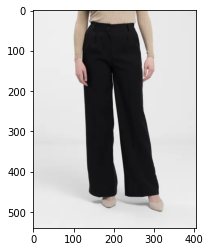

In [9]:
"""
Let's look at the example: product title and image
"""
display(new_products.iloc[250])

img = cv2.imread(f"KazanExpress/{new_products.loc[250].product_id}.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.show()

***